In [1]:
import torch    
from Classifier_NN import Classifier_CIFAR
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from sklearn.model_selection import train_test_split
from NObSP_Decomposition import NObSP_NN_single_MultiOutput
import torch.nn.functional as F

In [2]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [4]:
# Cargar los tensores guardados
output_tensors = torch.load('train_tensors_MNIST.pth')
y = torch.load('train_labels_MNIST_simple.pth')

X = torch.cat(output_tensors).detach()
y = F.one_hot(torch.cat(y))

labels = tuple(str(i) for i in range(10)) 

In [7]:
X.shape

torch.Size([80000, 64])

In [4]:
X_sample = []
y_sample = []

sample_size = 250
# Supongamos que 'num_classes' es el número de clases en tus etiquetas
for i in range(10):
    indices = torch.where(y.argmax(dim=1) == i)[0]
    indices = indices[torch.randperm(len(indices))[:sample_size]]
    X_sample.append(X[indices])
    y_sample.append(y[indices])

# Verifica que cada tensor en X_sample y y_sample es diferente
for i in range(len(X_sample)):
    for j in range(i + 1, len(X_sample)):
        assert id(X_sample[i]) != id(X_sample[j])
        assert id(y_sample[i]) != id(y_sample[j])

X = torch.cat(X_sample)
y = torch.cat(y_sample)

In [5]:
X

tensor([[ 0.3977, 12.1394,  0.2962,  ...,  7.4552,  6.6405,  4.1055],
        [-0.6695,  3.2584,  2.4549,  ...,  2.5789,  2.9193,  4.6801],
        [-0.4993,  0.3279, -4.4348,  ...,  0.6991,  9.4634,  6.4958],
        ...,
        [ 5.3995, -1.8655,  2.7138,  ...,  2.2497,  2.9938, -1.0074],
        [ 0.2271, -2.8027,  0.8484,  ...,  1.2474,  3.7062, -0.4695],
        [-0.6701, -4.9228, -0.1068,  ..., -1.8410, -1.5339, -2.3461]])

In [6]:
y

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1]])

# Ejecutando el algoritmo

In [7]:
N = np.size(X,0); # Defining the number of datapoints
in_feat = np.size(X,1)

In [8]:
t = np.arange(0, N)
train_split = int(0.8 * N)
p = 10

In [9]:
epochs = 5000
learning_rate = 0.001

In [10]:
# Split of the data for training and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size = train_split,
    random_state=42
) 

## Creating model for single nonlinear effects

model_1 = Classifier_CIFAR(in_number=128) # Creating the model
loss_fcn = nn.CrossEntropyLoss() # Definning loss function
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

# Training loop for the model 1

In [11]:
for epoch in range(epochs):
    model_1.train() # Setting the model in training mode
    y_prob, x_p, y_lin = model_1(X_train) #forward pass
    
    loss = loss_fcn(y_prob,
                    y_train.float())  # Compute Loss
    loss.backward() # compute backward
    optimizer.step() # update parameters
    optimizer.zero_grad() #zero grad optimizer
    
    ## Testing
    model_1.eval() # Setting the model in evalaution mode
    with torch.inference_mode():
        y_prob_pred, x_trans, y_lin_pred = model_1(X_test) # Estimating th emodel output in test data
    
    test_loss = loss_fcn(y_prob_pred,
                         y_test.float()) # Evaluating loss
    
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | test Loss: {test_loss:.5f}') # Printing the performance of the model as it is trained

Epoch: 0 | Loss: 2.30396 | test Loss: 2.28181
Epoch: 100 | Loss: 1.46915 | test Loss: 1.48348
Epoch: 200 | Loss: 1.46808 | test Loss: 1.48242
Epoch: 300 | Loss: 1.46806 | test Loss: 1.48245
Epoch: 400 | Loss: 1.46805 | test Loss: 1.48247
Epoch: 500 | Loss: 1.46805 | test Loss: 1.48242
Epoch: 600 | Loss: 1.46805 | test Loss: 1.48239
Epoch: 700 | Loss: 1.46804 | test Loss: 1.48233
Epoch: 800 | Loss: 1.46757 | test Loss: 1.48304
Epoch: 900 | Loss: 1.46757 | test Loss: 1.48288
Epoch: 1000 | Loss: 1.46757 | test Loss: 1.48272
Epoch: 1100 | Loss: 1.46757 | test Loss: 1.48262
Epoch: 1200 | Loss: 1.46757 | test Loss: 1.48257
Epoch: 1300 | Loss: 1.46757 | test Loss: 1.48253
Epoch: 1400 | Loss: 1.46757 | test Loss: 1.48249
Epoch: 1500 | Loss: 1.46757 | test Loss: 1.48246
Epoch: 1600 | Loss: 1.46757 | test Loss: 1.48244
Epoch: 1700 | Loss: 1.46757 | test Loss: 1.48241
Epoch: 1800 | Loss: 1.46757 | test Loss: 1.48239
Epoch: 1900 | Loss: 1.46757 | test Loss: 1.48236
Epoch: 2000 | Loss: 1.46757 | te

In [12]:
model_1.eval()  # Setting the model in evaluation mode
with torch.inference_mode():
    y_prob_1, x_trans_total_1, y_est_1 = model_1(
        X
    )  # Computing the nonlinear transformation of the input data X

P_xy_1, y_e_1, Alpha_NN_1 = NObSP_NN_single_MultiOutput(
    X, y_est_1, model_1
)  # Computing the decomposition using NObSP. The Alpha parameters are the weigths for the Interpretation Layer

y_e_Alpha_1 = np.zeros((N, in_feat, p))
for i in range(p):
    y_e_Alpha_1[:, :, i] = (
        x_trans_total_1 @ Alpha_NN_1[:, i * in_feat : i * in_feat + in_feat]
    )  # Computing the decomposition using the Alpha coefficients, out-of-sample extension

y_e_1 = y_e_1.cpu()

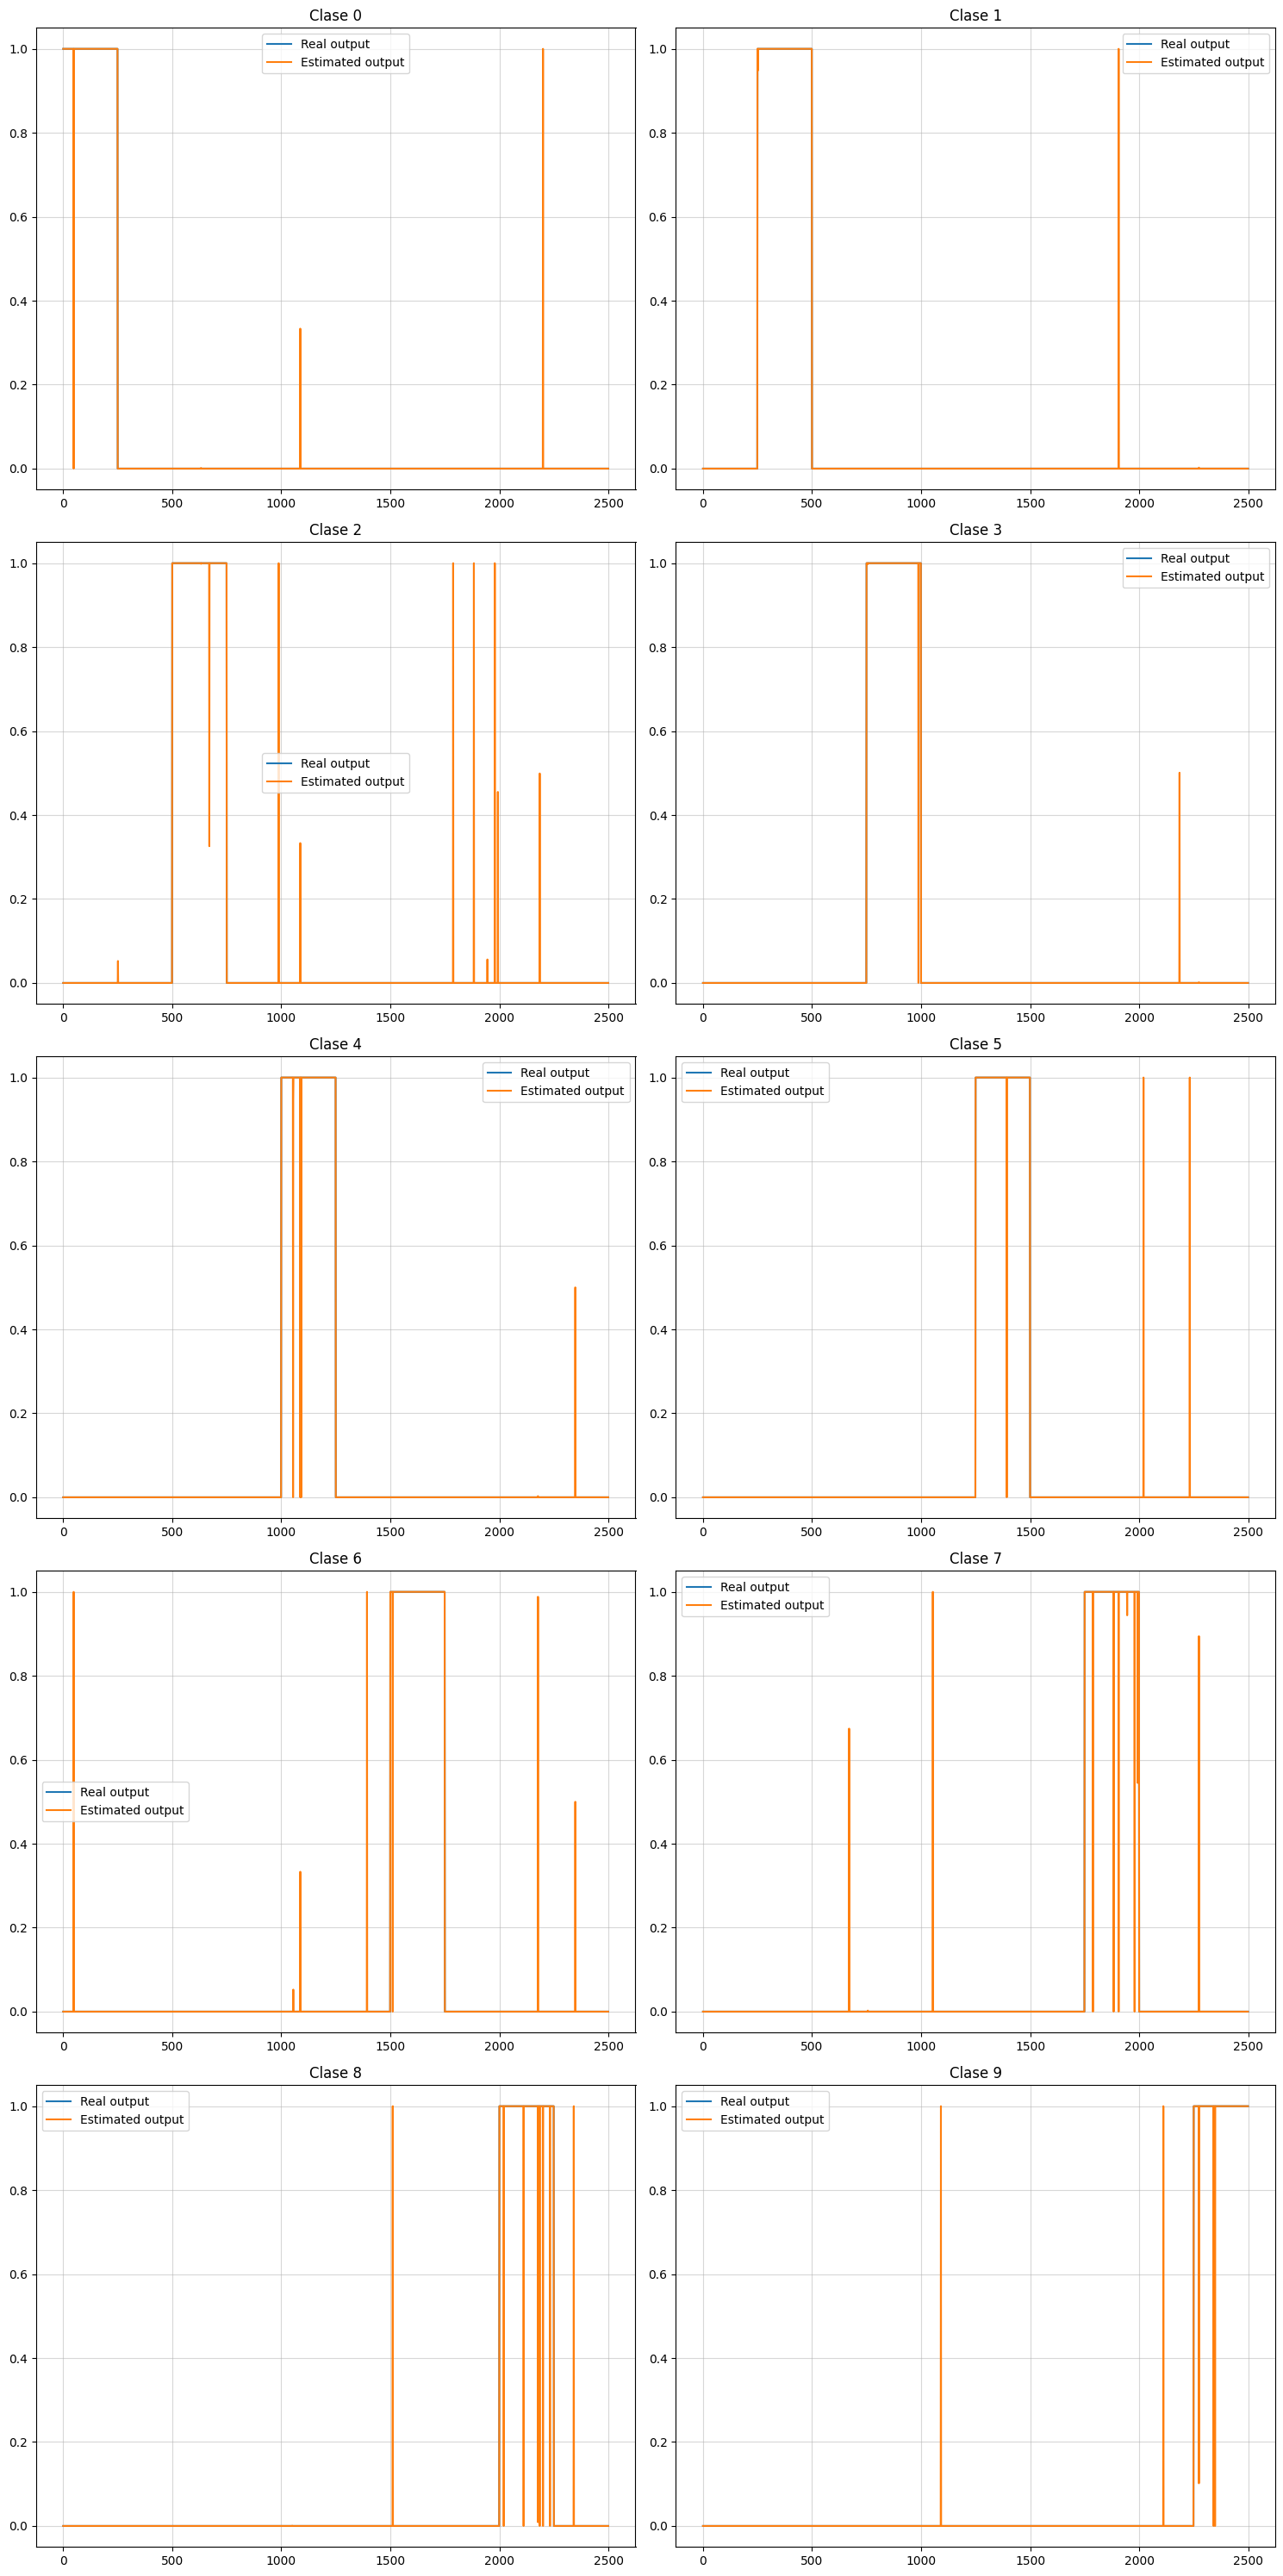

In [13]:
p = y.shape[1]
filas = p // 3 + (p % 3 > 0)  # Calcula el número de filas necesarias
fig, axs = plt.subplots(5, 2, figsize=(15, 30))  # Crea una gráfica con 'filas' filas y 3 columnas

axs = axs.ravel()  # Convierte el array de ejes en un array 1D para facilitar su manejo

for i in range(p):
    axs[i].plot(t, y[:, i], label="Real output")  # Estimated output vs real output
    axs[i].plot(t, y_prob_1[:, i], label="Estimated output")
    axs[i].legend()
    axs[i].grid(alpha=0.5)
    axs[i].set_title(f"Clase {labels[i]}")

plt.tight_layout()
plt.show()

In [14]:
labels

('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

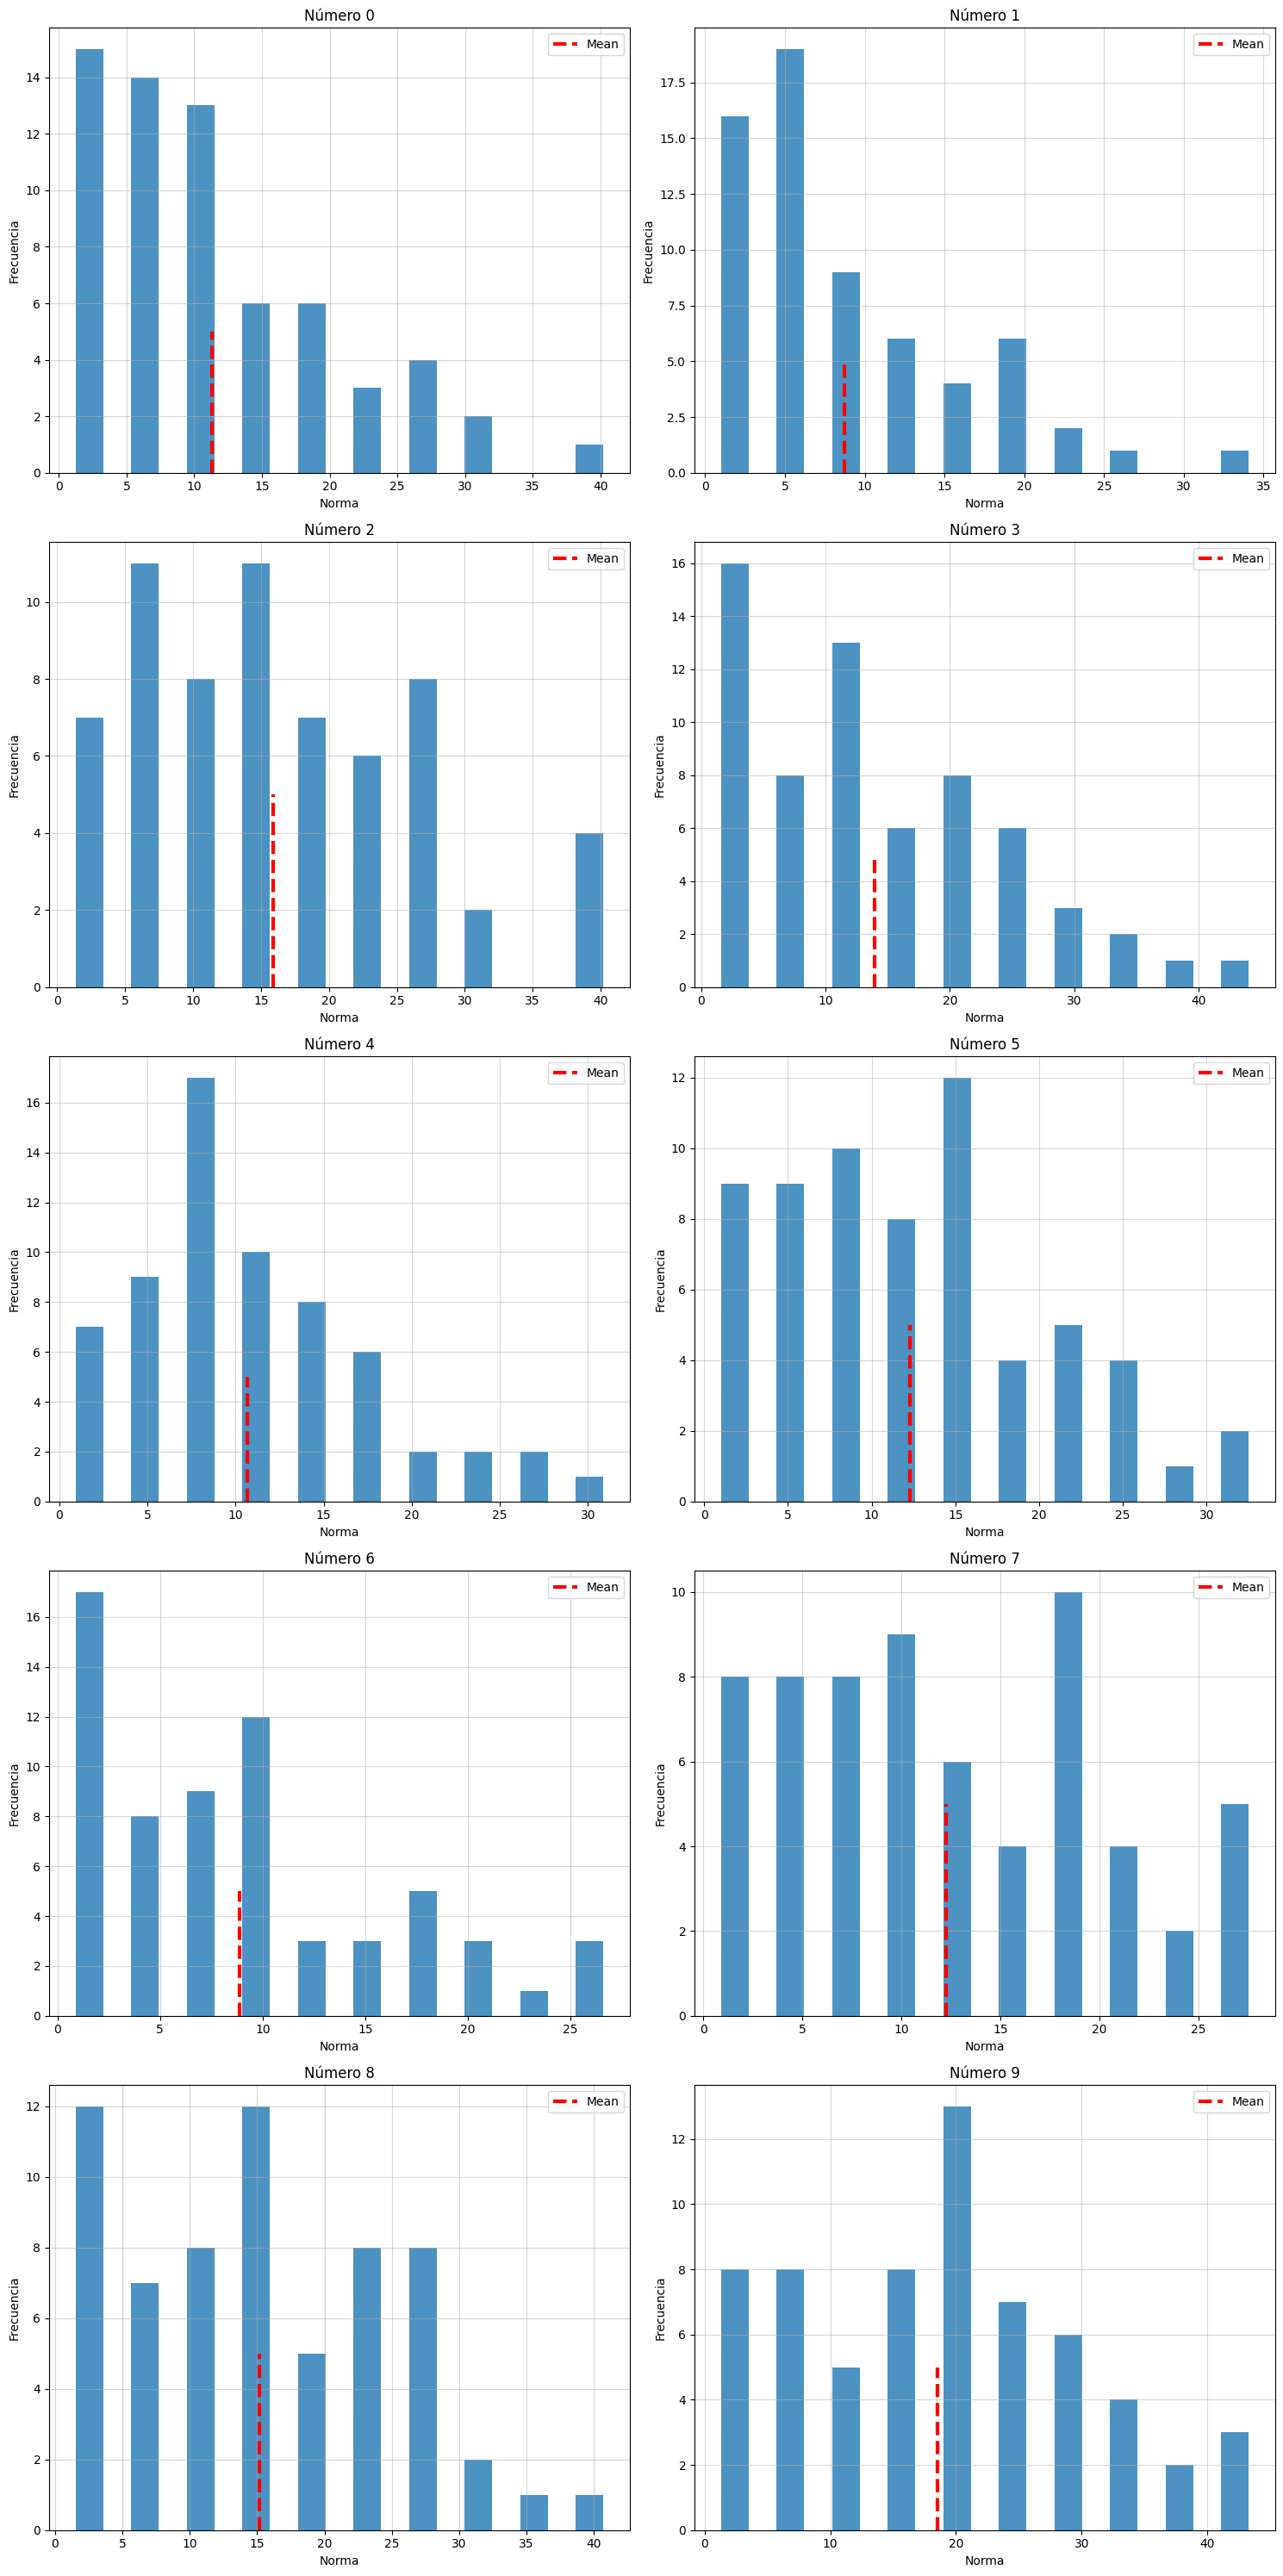

In [15]:
p = y.shape[1]
filas = p // 3 + (p % 3 > 0)  # Calcula el número de filas necesarias
fig, axs = plt.subplots(5, 2, figsize=(15, 30))  # Crea una gráfica con 'filas' filas y 3 columnas

axs = axs.ravel()  # Convierte el array de ejes en un array 1D para facilitar su manejo

for i in range(p):
    axs[i].hist(
        [torch.linalg.norm(y_e_1[:, j, i] - y_e_1[:, j, i].mean()) for j in range(64)],
        rwidth=0.5,
        alpha = 0.8
    )
    axs[i].vlines(
        np.mean([torch.linalg.norm(y_e_1[:, j, i] - y_e_1[:, j, i].mean()) for j in range(64)]),
        0,
        5,
        color="red",
        label="Mean",
        linestyle="--",
        linewidth=3
    )
    axs[i].grid(alpha=0.5)
    axs[i].set_title(f"Número {labels[i]}")
    axs[i].set_xlabel("Norma")
    axs[i].set_ylabel("Frecuencia")
    axs[i].legend()
    
plt.tight_layout()
plt.show()

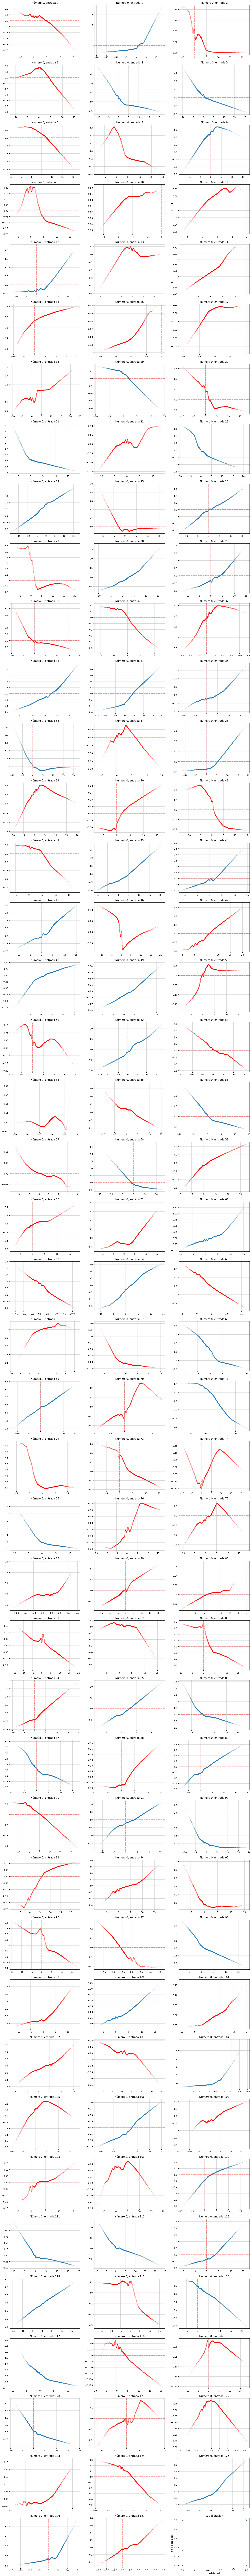


Se usaron 51 entradas para la estimación del número 0


In [16]:
# Supongamos que 'n' es el número de tensores en X
n = X.shape[1]

# Plotting the decomposition
i = 0
used = 0

fig, axs = plt.subplots(n // 3 + 1, 3, figsize=(20, 5 * (n // 3 + 1)))
for j in range(n):
    norm = torch.linalg.norm(y_e_1[:, j, i] - y_e_1[:, j, i].mean())
    tolerance = np.mean([torch.linalg.norm(y_e_1[:, k, i] - y_e_1[:, k, i].mean()) for k in range(64)])
    row = j // 3
    col = j % 3
    axs[row, col].axhline(0, color="red", linestyle="--", alpha=0.4)
    axs[row, col].axvline(0, color="red", linestyle="--", alpha=0.4)
    if norm > tolerance:
        axs[row, col].scatter(
            X[:, j], y_e_1[:, j, i] - y_e_1[:, j, i].mean(), s=10, alpha = 0.05
        )  # Estimated nonlinear contribution of xj on the output
        used +=1
    else:
       axs[row, col].scatter(
            X[:, j], y_e_1[:, j, i] - y_e_1[:, j, i].mean(), s=10, alpha = 0.05, color = 'red'
        )
    axs[row, col].set_title(f"Número {labels[i]}, entrada {j}")
    axs[row, col].grid(alpha=0.5)

axs[n // 3, n % 3].scatter(
    y[:, i].cpu(), y_prob_1[:, i].cpu(), marker="x"
)  # Calibration plot real output vs estimated output
axs[n // 3, n % 3].set_title(f"{labels[i+1]}, Calibración")
axs[n // 3, n % 3].set_xlabel("Salida real")
axs[n // 3, n % 3].set_ylabel("Salida estimada")
plt.show()
print()
print(f"Se usaron {used} entradas para la estimación del número {labels[i]}")

In [17]:
used_all = {
    labels[i]: [] for i in range(p)
}

for i in range(p):
    for j in range(64):
        norm = torch.linalg.norm(y_e_1[:, j, i] - y_e_1[:, j, i].mean())
        tolerance = np.mean([torch.linalg.norm(y_e_1[:, k, i] - y_e_1[:, k, i].mean()) for k in range(64)])
        if norm > tolerance:
            used_all[labels[i]].append(j)

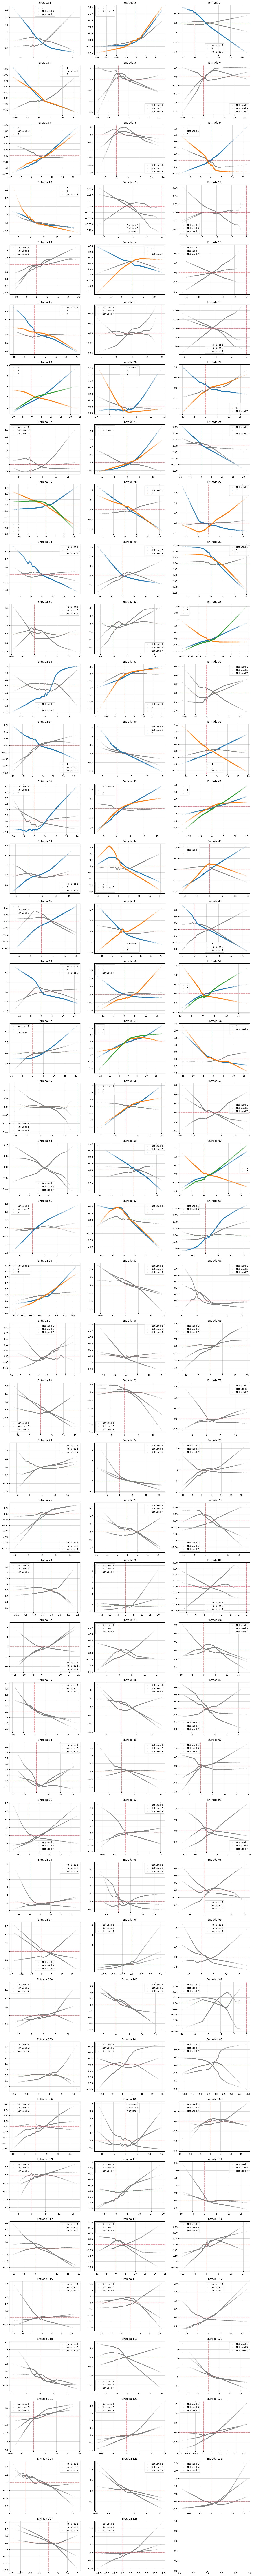

In [18]:
# Supongamos que 'n' es el número de tensores en X
n = X.shape[1] 

#  Solicitando las clases que se desean visualizar
i1 = 1
i2 = 5
i3 = 7

# Creando los subgráficos
fig, axs = plt.subplots(n // 3+1, 3, figsize=(20, 5 * (n // 3 + 1)))

# Plotting the decomposition for all three classes
for j in range(n):
    row = j // 3
    col = j % 3
    axs[row, col].axhline(0, color="red", linestyle="--", alpha=0.4)
    axs[row, col].axvline(0, color="red", linestyle="--", alpha=0.4)
    for i in [i1, i2, i3]:
        if j in used_all[labels[i]]:
            axs[row, col].scatter(
                X[:, j], y_e_1[:, j, i] - y_e_1[:, j, i].mean(), label=f"{labels[i]}", s=10, alpha = 0.1
            )
        else:
            axs[row, col].scatter(
                X[:, j], y_e_1[:, j, i] - y_e_1[:, j, i].mean(), label=f"Not used {labels[i]}", s=5, alpha = 0.1, color = 'gray'
            )
    axs[row, col].set_title(f"Entrada {j+1}")
    axs[row, col].legend()
    axs[row, col].grid(alpha=0.5)
plt.show() 